# Fairest Lines


- For Route Change - we can find somewhere else in Notebook, anyways it is in slides for PAPER*** to mention 
- No need for further adaptations and analysis, keep it simple!

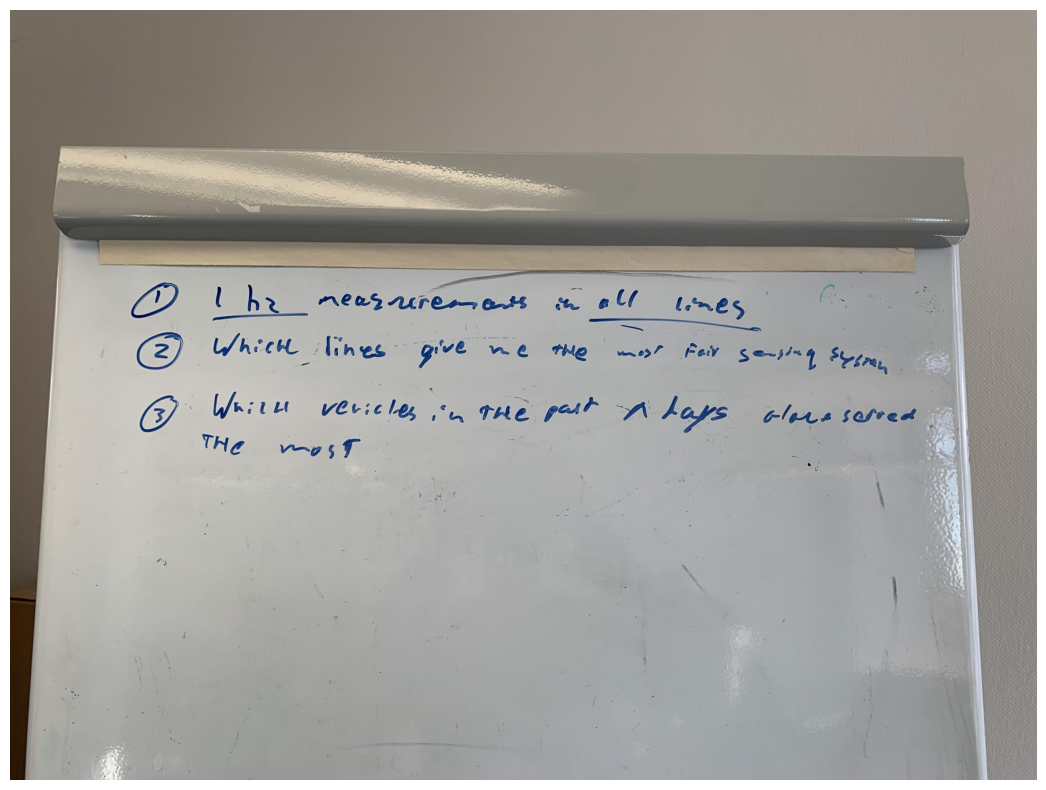

In [136]:
import matplotlib.pyplot as plt
from PIL import Image
image_path = 'Steps_Fabio_Thursday.jpg'  # Replace with your image path
image = Image.open(image_path)

plt.figure(figsize=(20, 10))
# Display the image
plt.imshow(image)
plt.axis('off')  # Hide axis
  # Adjusts the size of the image display
plt.show()

## Statistics all lines with buffer 100m

### Add libraries

In [137]:
import pandas as pd
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator
from scipy.spatial.distance import euclidean



### Task 1: Load Data

In [138]:
lines_average_df = pd.read_csv('lines_average_NEW.csv')

### Scatter Plot Migration

In [139]:
def plot_migration_scatter(df):
    """
    Scatter of 'Mig. Dutch' vs 'Mig. Non-Western' for each line,
    non‑Amsterdam points in black/green, Amsterdam in red.
    
    Returns:
    - fig : matplotlib Figure object
    """
    plt.style.use('default')
    fig, ax = plt.subplots(figsize=(12, 8))

    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.yaxis.set_minor_locator(AutoMinorLocator(5))
    ax.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=1)
    ax.grid(True, which='minor', linestyle=':', linewidth=0.3, alpha=1)

    mask_ams = df['Area'] == 'Amsterdam'
    mask_others = ~mask_ams

    df['marker_size'] = df['Area'].apply(lambda x: 200 if x == 'Amsterdam' else 50)

    ax.scatter(
        df.loc[mask_ams, 'A_nederlan'],
        df.loc[mask_ams, 'A_n_west_m'],
        s=df.loc[mask_ams, 'marker_size'],
        c='#e15989',
        label='Amsterdam',
        edgecolors='black',
        alpha=1
    )
    ax.scatter(
        df.loc[mask_others, 'A_nederlan'],
        df.loc[mask_others, 'A_n_west_m'],
        s=df.loc[mask_others, 'marker_size'],
        c='#8cc63e',
        alpha=0.8
    )

    for _, row in df.iterrows():
        ax.text(
            row['A_nederlan'],
            row['A_n_west_m'],
            str(row['route_shor']),
            fontsize=10,
            ha='right',
            va='bottom'
        )

    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.tick_params(axis='both', which='both', length=0)

    ax.set_xlabel('Migration Dutch', fontweight='bold')
    ax.set_ylabel('Migration Non‑Western', fontweight='bold')
    ax.set_title('Migration Background by Line', fontweight='bold')
    ax.legend()

    plt.tight_layout()
    return fig


## Find fairest line

#### Migration Background

In [140]:

def find_closest_lines_migration(lines_average_df):
    """
    Calculates Euclidean distance of each line to Amsterdam's migration composition.
    Returns DataFrame sorted by proximity (closest first).

    # ADAPT FOR CITY

    """
    # Extract Amsterdam reference values
    city_values = lines_average_df.loc[
        lines_average_df['Area'] == 'Amsterdam',
        ['A_nederlan', 'A_west_mig', 'A_n_west_m']
    ].values[0]

    # Compute distances
    lines_average_df['distance'] = lines_average_df.apply(
        lambda row: euclidean(city_values, row[['A_nederlan', 'A_west_mig', 'A_n_west_m']]),
        axis=1
    )

    # Filter out Amsterdam and sort
    closest_lines_df = lines_average_df[lines_average_df['Area'] != 'Amsterdam'].sort_values(by='distance').reset_index(drop=True)
    return closest_lines_df


#### Migration + Age + Wealth (WOZ) Multiple variables

In [ ]:

def find_closest_lines_all(lines_average_df):
    """
    Calculates Euclidean distance of each line to Amsterdam's full socio-demographic and housing profile.
    Uses all key variables: age groups, property value, migration groups.

    Returns:
    - DataFrame sorted by proximity (closest first).
    """

    # Extract Amsterdam reference values (full profile)
    ams_values = lines_average_df.loc[
        lines_average_df['Area'] == 'Amsterdam',
        ['A_0_15', 'A_15_25', 'A_25_45', 'A_45_65', 'A_65+', 
         'G_woz_woni', 'A_nederlan', 'A_west_mig', 'A_n_west_m']
    ].values[0]

    # Compute distances
    lines_average_df['distance'] = lines_average_df.apply(
        lambda row: euclidean(
            ams_values, 
            row[['A_0_15', 'A_15_25', 'A_25_45', 'A_45_65', 'A_65+', 
                 'G_woz_woni', 'A_nederlan', 'A_west_mig', 'A_n_west_m']]
        ),
        axis=1
    )

    # Filter out Amsterdam and sort
    closest_lines_df = lines_average_df[lines_average_df['Area'] != 'Amsterdam'].sort_values(by='distance').reset_index(drop=True)
    
    return closest_lines_df


### Plot Fairest Lines

In [141]:
def plot_line_fairness(closest_lines_df, lines_gdf, ams_gdf, columns = None):
    """
    Merge closest lines with geometries and plot fairness map.
    Ensures matching CRS between Amsterdam boundary and lines.
    """

    # Merge geometries
    merged_df = lines_gdf.merge(closest_lines_df, left_on='route_shor', right_on='route_shor')
    merged_df = merged_df.drop(columns='route_shor')
    merged_df = merged_df[[col for col in merged_df.columns if col != 'geometry'] + ['geometry']]
    closest_lines_gdf = merged_df.sort_values(by='distance')

    # Ensure matching CRS
    if ams_gdf.crs != lines_gdf.crs:
        ams_gdf = ams_gdf.to_crs(lines_gdf.crs)

    # Create plot
    fig, ax = plt.subplots(figsize=(12, 8), facecolor='white')
    ams_gdf.boundary.plot(ax=ax, color='black', linewidth=1)

    # Plot lines
    ax = closest_lines_gdf.plot(
        column='distance',
        ax=ax,
        legend=False,
        cmap='Greens',
        linewidth=2
    )

    # Colorbar
    vmin, vmax = closest_lines_gdf['distance'].min(), closest_lines_gdf['distance'].max()
    sm = mpl.cm.ScalarMappable(cmap='Greens', norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax)) # Craate nice colors
    sm._A = []
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', shrink=0.5, pad=0.02)
    cbar.set_label("Euclidean Distance")
    cbar.outline.set_visible(False)

    # Styling
    ax.set_axis_off()
    ax.set_title(f'Line Fairness for {columns}', fontsize=14, fontweight='bold')
    plt.tight_layout()

    return fig


In [142]:

def plot_top_closest_lines(closest_lines_df, lines_gdf, ams_gdf, top_n=5,  columns = None):
   
    # Merge to add geometry
    merged = lines_gdf.merge(closest_lines_df, on='route_shor')
    merged = merged.drop(columns='route_shor')
    merged = merged[[col for col in merged.columns if col != 'geometry'] + ['geometry']]
    closest_lines_gdf = merged.sort_values(by='distance')

    # Select top N lines
    top_closest_lines = closest_lines_gdf.nsmallest(top_n, 'distance')

    # Ensure matching CRS
    if ams_gdf.crs != closest_lines_gdf.crs:
        ams_gdf = ams_gdf.to_crs(closest_lines_gdf.crs)

    # Plot
    fig, ax = plt.subplots(figsize=(12, 8), facecolor='white')
    top_closest_lines.plot(ax=ax, color='black', linewidth=2)

    top_closest_lines.boundary.plot(ax=ax, color='black', linewidth=2)
    ams_gdf.boundary.plot(ax=ax, color='black', linewidth=0.5)

    ax.set_axis_off()
    plt.title(f'The Fairest Line(s) {columns}', fontsize=14, fontweight='bold')
    plt.show()


 # FINAL FUNCTION | LINES FAIRNESS CALCULATION AND PLOTS

In [1]:
def migration_fairness_lines(lines_average_df, lines_gdf, ams_gdf, top_n=5, columns = None):
    """
    Pipeline for migration fairness analysis:
    1. Scatter plot of migration groups.
    2. Find closest lines based on migration composition.
    3. Plot fairness map (all lines).
    4. Plot top N fairest lines.
    """

    # Step 1: Scatter plot of migration background
    migration_plot_fig = plot_migration_scatter(lines_average_df)

    # Step 2: Find closest lines (migration-based)
    closest_mig = find_closest_lines_migration(lines_average_df)

    # Step 3: Plot fairness map (all lines)
    fairness_lines_mig_fig = plot_line_fairness(closest_mig, lines_gdf, ams_gdf, columns)

    # Step 4: Plot top N fairest lines
    top_fair_lines_mig_fig = plot_top_closest_lines(closest_mig, lines_gdf, ams_gdf, top_n, columns)

    return closest_mig, migration_plot_fig, fairness_lines_mig_fig, top_fair_lines_mig_fig


In [ ]:
def all_fairness_lines(lines_average_df, lines_gdf, ams_gdf, columns = None,  top_n=10):
    """
    Pipeline for overall fairness analysis (all attributes: age, migration, WOZ):
    1. Find closest lines based on full socio-demographic and housing profile.
    2. Plot fairness map (all lines).
    3. Plot top N fairest lines.

    """

    # Step 1: Find closest lines (full attribute profile)
    closest_all = find_closest_lines_all(lines_average_df)

    # Step 2: Plot fairness map (all lines)
    fairness_lines_fig = plot_line_fairness(closest_all, lines_gdf, ams_gdf, columns)

    # Step 3: Plot top N fairest lines
    top_fair_lines_fig = plot_top_closest_lines(closest_all, lines_gdf, ams_gdf, top_n=top_n, columns = columns)
 

    return closest_all, fairness_lines_fig, top_fair_lines_fig


In [164]:
# Usage

ams_gdf = gpd.read_file('gemeente_T.shp')
lines_gdf = gpd.read_file("data/public_transport.gpkg", driver="GPKG")
lines_average_df = pd.read_csv('lines_average_NEW.csv')

c:\Users\pkoljensic\OneDrive - Delft University of Technology\Desktop\PYTHON\projects\sensing\sensing_env\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: driver GPKG does not support open option DRIVER
  return ogr_read(


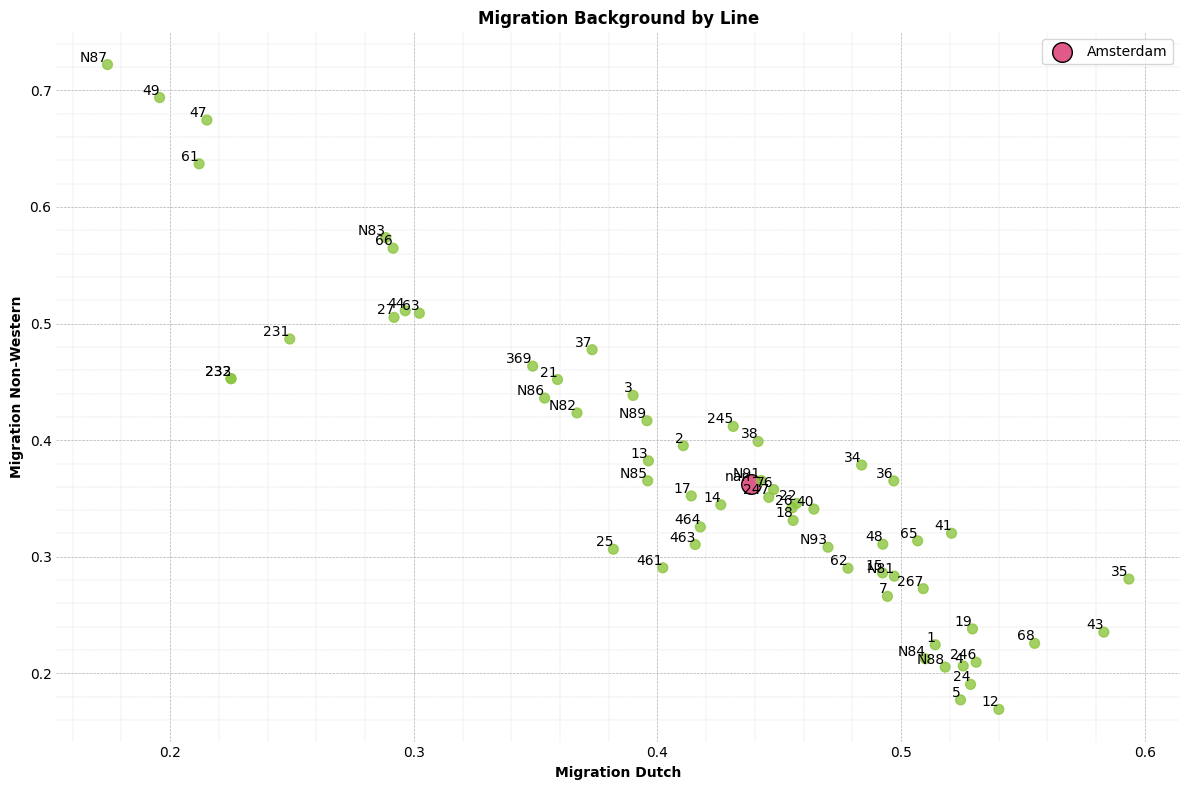

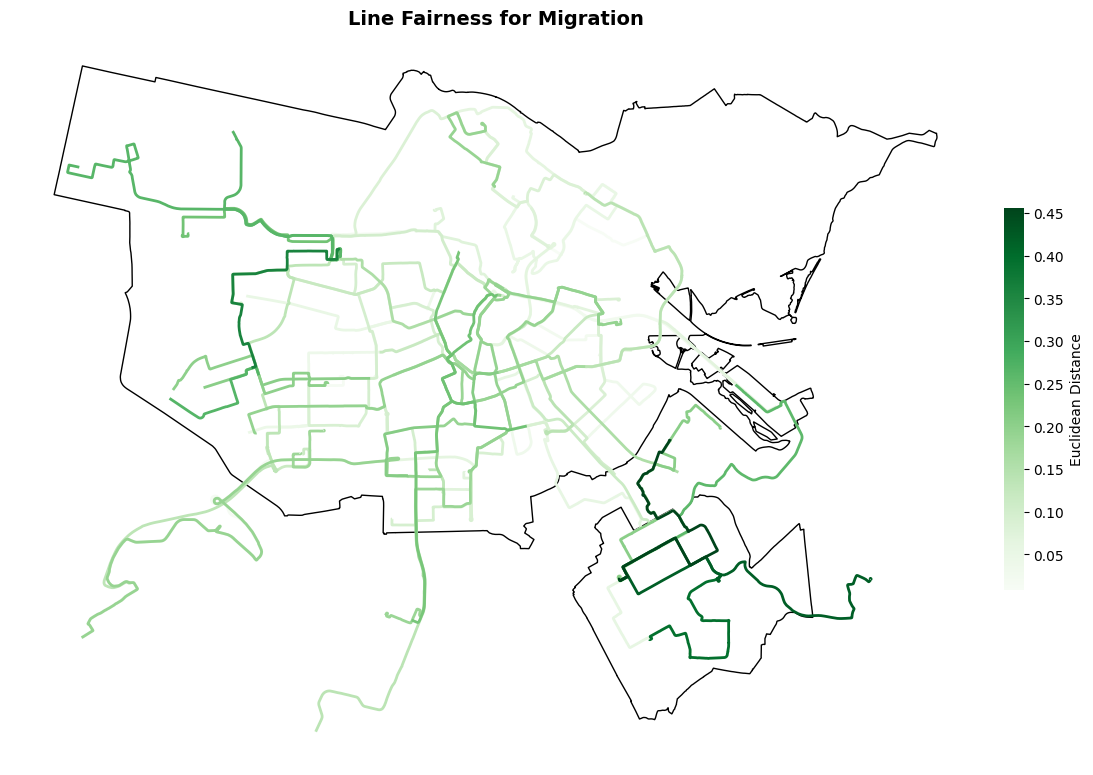

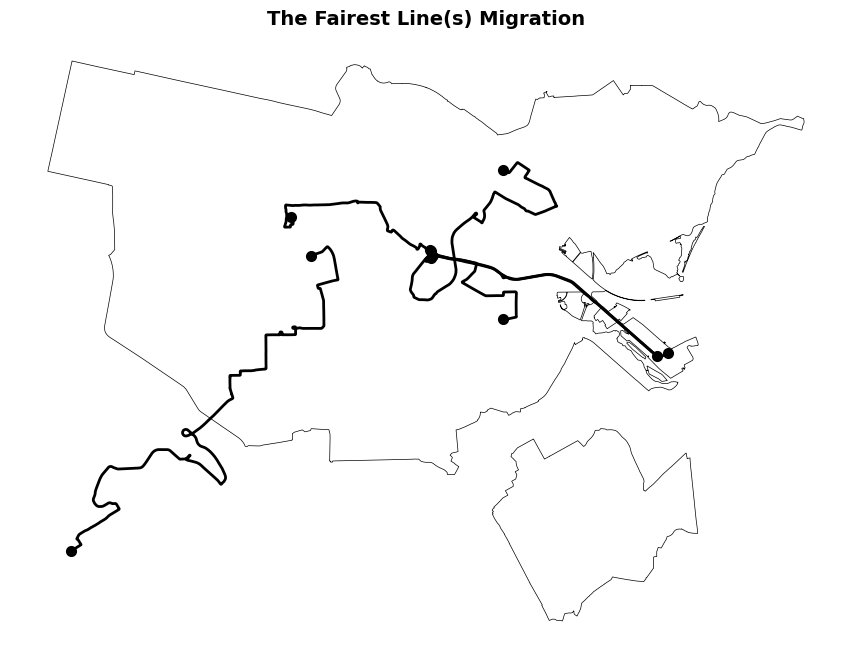

(<Figure size 1200x800 with 1 Axes>, <Figure size 1200x800 with 2 Axes>, None)

In [165]:
migration_fairness_lines(lines_average_df, lines_gdf, ams_gdf, top_n=5, columns = 'Migration')

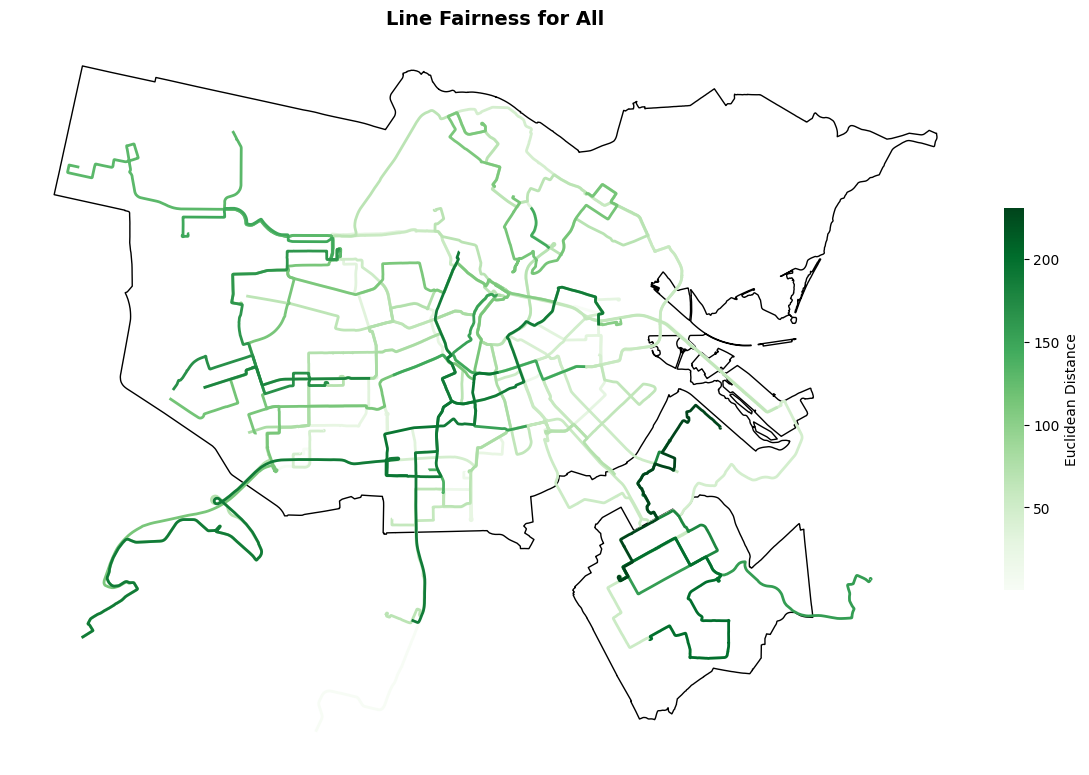

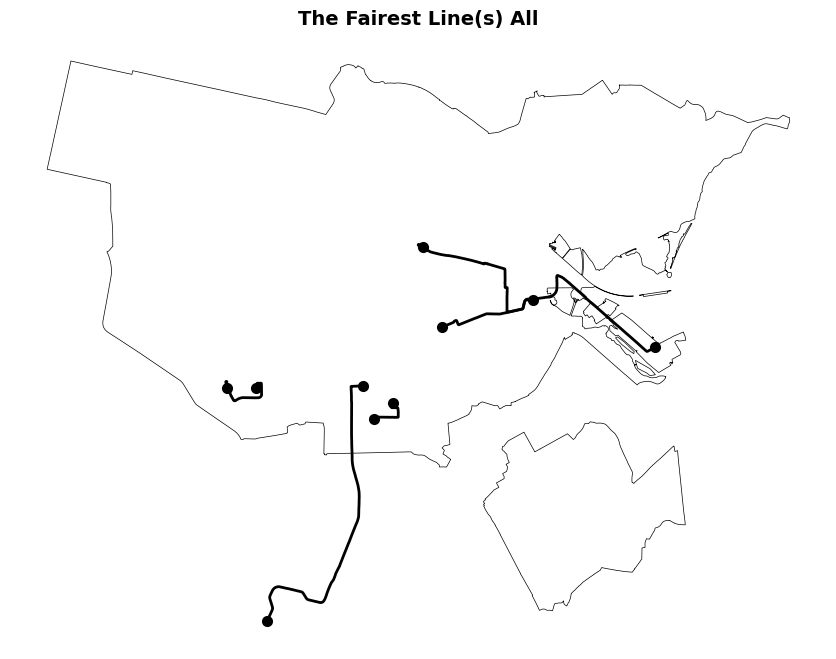

(<Figure size 1200x800 with 2 Axes>, None)

In [166]:
all_fairness_lines(lines_average_df, lines_gdf, ams_gdf, top_n=5, columns= 'All')